In [1]:
import pandas as pd 
credentials = pd.read_csv('credentials.csv')
consumer_key = credentials['consumer_key'][0]
consumer_secret = credentials['consumer_secret'][0]
access_token = credentials['access_token'][0]
access_secret = credentials['access_secret'][0]
 
import tweepy
from tweepy import OAuthHandler
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True)

import warnings
warnings.simplefilter('ignore')

In [84]:
from pymongo import MongoClient
client = MongoClient()
news_tweets = client.tweets_db.new_tweets


In [75]:
news_tweets.count()

89932

In [149]:
import pandas as pd
tweets_df = pd.DataFrame([[tw['id'], tw['text'], tw['user']['screen_name']] 
                           for tw in news_tweets.find()], columns=['id', 'text', 'user'])


In [150]:
import numpy as np
np.unique(tweets_df.user).tolist()

[u'BBCTech',
 u'BNNBloomberg',
 u'CBCHealth',
 u'CBSHealth',
 u'ETEconomyNews',
 u'EverydayHealth',
 u'FOXSportsNews',
 u'FinancialTimes',
 u'ForbesTech',
 u'FoxNewsTech',
 u'HTSportsNews',
 u'HealthHive',
 u'KHNews',
 u'NBCNewsHealth',
 u'NBCNewsTech',
 u'NPRHealth',
 u'NewsdaySports',
 u'ReutersTech',
 u'SkyNewsWeather',
 u'SkySportsNews',
 u'TechCrunch',
 u'TheWeatherNetUS',
 u'bbchealth',
 u'bn9weather',
 u'breakingbytes',
 u'ftfinancenews',
 u'fttechnews',
 u'technology']

In [151]:
del users_df['cat']

In [152]:
users_df = pd.DataFrame(np.unique(tweets_df.user).tolist(), columns=['user'])

In [153]:
cats = [('Business',  ['busi', 'econo', 'finan', 'BNNBloomberg']),
        ('Traffic', None),
        ('Tech', ['tech', 'breakingbytes']),
        ('Heath', ['health', 'KHNews']),
        ('Sports', 'sport'),
        ('Weather', None),
       ]
for cat in cats:
    keywords = cat[1]
    cat_name = cat[0]
    if keywords is None:
        keywords = cat_name
    if not isinstance(keywords, list):
        keywords = [keywords]
    print cat
    for index, u in zip(users_df.index, users_df.user):
        for kw in keywords:
            if u.lower().find(kw.lower()) != -1:
                print("\t%s %s"% (u, kw))
                users_df.loc[index, 'cat'] = cat_name
                break

('Business', ['busi', 'econo', 'finan', 'BNNBloomberg'])
	BNNBloomberg BNNBloomberg
	ETEconomyNews econo
	FinancialTimes finan
	ftfinancenews finan
('Traffic', None)
('Tech', ['tech', 'breakingbytes'])
	BBCTech tech
	ForbesTech tech
	FoxNewsTech tech
	NBCNewsTech tech
	ReutersTech tech
	TechCrunch tech
	breakingbytes breakingbytes
	fttechnews tech
	technology tech
('Heath', ['health', 'KHNews'])
	CBCHealth health
	CBSHealth health
	EverydayHealth health
	HealthHive health
	KHNews KHNews
	NBCNewsHealth health
	NPRHealth health
	bbchealth health
('Sports', 'sport')
	FOXSportsNews sport
	HTSportsNews sport
	NewsdaySports sport
	SkySportsNews sport
('Weather', None)
	SkyNewsWeather Weather
	TheWeatherNetUS Weather
	bn9weather Weather


In [154]:
users_df

,user,cat
0,BBCTech,Tech
1,BNNBloomberg,Business
2,CBCHealth,Heath
3,CBSHealth,Heath
4,ETEconomyNews,Business
5,EverydayHealth,Heath
6,FOXSportsNews,Sports
7,FinancialTimes,Business
8,ForbesTech,Tech
9,FoxNewsTech,Tech


In [155]:
users_df_fillna = users_df.fillna('Other')

In [13]:
users = api.friends('@amnasri2', count=100)
#[u.screen_name for u in users]

In [156]:
news_tweets.count()

86726

In [157]:
users_df_fillna.set_index('user', inplace=True)

In [158]:
tweets_df['cat'] = tweets_df['user'].apply(lambda x: users_df_fillna.loc[x])

In [159]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [160]:
tweets_df['cat_encoded'] = label_encoder.fit_transform(tweets_df.cat)

In [161]:
tweets_df = tweets_df.sample(frac=1)
tweets_df.head()

,id,text,user,cat,cat_encoded
49090,951857155216470016,Personality issue https://t.co/8uCMsal1Tq,bbchealth,Heath,1
84352,1013410917046980610,Expert says don't be fooled by hot water and l...,EverydayHealth,Heath,1
58774,1005053801714343936,Hawaii volcano's toll nears 600 homes destroye...,FoxNewsTech,Tech,3
28332,926571871637827584,RT @ChrisKStubbs: 'Let them win it themselves'...,FOXSportsNews,Sports,2
41134,813773571218612224,ICYMI: The deadliest type of skin cancer is on...,CBSHealth,Heath,1


In [83]:
from multiprocessing import Process

user_del_list =  [ u'CTVVancouver',
                  u'abcnews',
                  u'TIME',
                  u'TwitterNews',
u'NBCNews',
 u'BBCWorld'
 u'TIME',
 u'washingtonpost',
 u'news_welle',
 u'CBSNews',
]

#user_del_list = tweets_df[tweets_df['cat'] == 'Other']['user'].unique().tolist()

user_del_list =  [ u'CBCEnt']


In [86]:
from multiprocessing import Process, Pipe

def f(conn):
    client = MongoClient()
    news_tweets = client.tweets_db.new_tweets
    for user in user_del_list:
        conn.send([user])
        for id in tweets_df[tweets_df['user']==user]['id']:
            news_tweets.delete_one({'id':id})
    conn.close()

parent_conn, child_conn = Pipe()
p = Process(target=f, args=(child_conn,))
p.start()
#p.join()
    


In [148]:
print parent_conn.recv()


KeyboardInterrupt: 

In [163]:
cursor = news_tweets.find().sort([('timestamp', -1)]).limit(20)


In [317]:
import time
def collect_tweets(users):
    curr_count = news_tweets.count()
    now = time.time()
    print("Started collecting tweets")
    for user in users:
        #tweets = api.user_timeline(screen_name = user.screen_name, count=200)
        try:
            tweets = tweepy.Cursor(api.user_timeline,screen_name=user.screen_name).items()
        except:
            continue
            
        for tw in tweets:

            if news_tweets.find_one({'id':tw.id}):
                break

            try:
                news_tweets.insert_one(tw._json)
            except DuplicateKeyError:
                break
                
    new_count = news_tweets.count()
    new_time = time.time() - now
    print("Collected %d tweets in %.2f seconds" % (new_count - curr_count, new_time))
    

In [318]:
import threading
import time


class MyThread(threading.Thread):
    def __init__(self, interval, task, args=[], kwargs={}):
        super(MyThread, self).__init__()
        self.stop_ = False
        self.interval = interval
        self.args = args
        self.kwargs = kwargs
        self.task = task
        self.start()
        
    def run(self):
        while not self.stop_:
            self.task(*self.args, **self.kwargs)
            time.sleep(self.interval)
            
    def stop(self):
        self.stop_ = True
        
mythread = MyThread(15 * 60, collect_tweets, [users])

Started collecting tweets


In [279]:
mythread.stop()

In [325]:
news_tweets.count()

86144

In [165]:
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
import re
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        comments_clean = []
        for c in X:
            c = c.replace('\\\\', '\\')
            c = c.replace('\\n', ' ')
            #c = c.replace('\'', '')
            c = re.sub(r'[-_"]', '', c)
            c = re.sub(r'[*%&,?!;]', ' ', c)
            c = re.sub(r"(.)\1{2,}", '\g<1>', c)
            c = re.sub(r'\.(\s+|$)', ' ', c)
            c = re.sub(r'[^\x00-\x7F]+',' ', c)
            #c = re.sub(r'@[^ ]*', ' ', c)
            #c = re.sub(r'[0-9]+', ' ', c)
            c = re.sub(r'https?://[\w./]+', ' ', c)
            c = [wordnet_lemmatizer.lemmatize(wordnet_lemmatizer.lemmatize(w, pos='v')).lower() 
                          for w in c.split()]
            c = " ".join(w for w in c if len(w) > 2)
            #c = " ".join([w.lower() for w in c.split()])# if 3<=len(w)<=40])
            comments_clean.append(c)
        return comments_clean

prep = Preprocessor()

In [285]:
#tweets_df = pd.DataFrame([[tw['id'], tw['text'], tw['user']['screen_name']] 
#                           for tw in news_tweets.find()], columns=['id', 'text', 'user'])


In [166]:
tweets_df['user'].value_counts()

ForbesTech         3595
EverydayHealth     3420
TechCrunch         3385
FinancialTimes     3297
ReutersTech        3297
BNNBloomberg       3286
HTSportsNews       3283
NBCNewsHealth      3273
FoxNewsTech        3271
SkySportsNews      3266
bn9weather         3256
ftfinancenews      3252
TheWeatherNetUS    3247
technology         3237
SkyNewsWeather     3236
fttechnews         3233
NewsdaySports      3228
bbchealth          3223
CBSHealth          3223
BBCTech            3220
NPRHealth          3220
CBCHealth          3219
ETEconomyNews      3214
NBCNewsTech        3214
FOXSportsNews      3202
HealthHive         3200
breakingbytes      1725
KHNews                4
Name: user, dtype: int64

In [167]:
tweets_df['cat'].value_counts()

Tech        28177
Heath       22782
Business    13049
Sports      12979
Weather      9739
Name: cat, dtype: int64

In [122]:
import numpy as np

In [168]:
#tweets_id = np.array([tw['id'] for tw in news_tweets.find()])
#tweets_text = np.array([tw['text'] for tw in news_tweets.find()])
tweets_text_processed = prep.fit_transform(tweets_text)
#tweets_text_vec = tfidv_vectorizer.fit_transform(text_processed)
#tweets_text_count_vec = count_vectorizer.fit_transform(text_processed)

NameError: name 'tweets_text' is not defined

In [169]:
tweets_df['text_processed'] = prep.fit_transform(tweets_df['text'])

In [48]:
"""

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def lemmatize_stemming(text, stem=True):
    result = lemmatizer.lemmatize(text, pos='v')
    if stem:
        result = stemmer.stem(result)
    return result
    
def preprocess(text):
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
            and len(token) > 3 and len(token) < 40 \
            and token.isalpha:
            result.append(lemmatize_stemming(token, stem=False))
    return " ".join(result)


from sklearn.datasets import fetch_20newsgroups

#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = [preprocess(tw['text']) for tw in news_tweets.find()]
"""

'\n\nimport gensim\nfrom gensim.utils import simple_preprocess\nfrom gensim.parsing.preprocessing import STOPWORDS\nfrom nltk.stem import WordNetLemmatizer, SnowballStemmer\nfrom nltk.stem.porter import *\nimport numpy as np\nnp.random.seed(2018)\n\nstemmer = SnowballStemmer(\'english\')\nlemmatizer = WordNetLemmatizer()\n\ndef lemmatize_stemming(text, stem=True):\n    result = lemmatizer.lemmatize(text, pos=\'v\')\n    if stem:\n        result = stemmer.stem(result)\n    return result\n    \ndef preprocess(text):\n    \n    result = []\n    for token in gensim.utils.simple_preprocess(text):\n        if token not in gensim.parsing.preprocessing.STOPWORDS             and len(token) > 3 and len(token) < 40             and token.isalpha:\n            result.append(lemmatize_stemming(token, stem=False))\n    return " ".join(result)\n\n\nfrom sklearn.datasets import fetch_20newsgroups\n\n#dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=(\'headers\', \'footers\', \'quotes\'

In [170]:
tweets_df['cat'].value_counts()

Tech        28177
Heath       22782
Business    13049
Sports      12979
Weather      9739
Name: cat, dtype: int64

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.5, max_features=20000,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)',
                             use_idf=True)

tf_vectorizer = CountVectorizer(ngram_range=(1, 2), max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english', token_pattern=u'((?u)\\b\\w\\w+\\b|[#@]\w+)'
                             )

In [172]:
tfidf = tfidf_vectorizer.fit_transform(tweets_df['text_processed'])


In [173]:
tfidf.shape

(86726, 20000)

In [175]:
from sklearn.linear_model import LogisticRegression

In [176]:
lr = LogisticRegression()

In [178]:
from sklearn.cross_validation import cross_val_score

cross_val_score(lr, tfidf, tweets_df['cat_encoded'])

array([ 0.8927052 ,  0.89165629,  0.89386654])

In [179]:
import numpy as np
np.logspace(-1, 1, 5)

array([  0.1       ,   0.31622777,   1.        ,   3.16227766,  10.        ])

In [181]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(lr, param_grid={'C': np.logspace(-1, 1, 5)}, n_jobs=3)
gs.fit(tfidf, tweets_df['cat_encoded'])

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'C': array([  0.1    ,   0.31623,   1.     ,   3.16228,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [182]:
gs.best_score_

0.90230150127989295

In [183]:
gs.best_params_

{'C': 10.0}

In [218]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
cross_val_score(rf, tfidf, tweets_df['cat_encoder'], n_jobs=3)

array([ 0.79007463,  0.79326954,  0.79076815])

In [185]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    tfidf, tweets_df['cat_encoded'], test_size=0.33, random_state=42)

In [186]:
lr = gs.best_estimator_

In [187]:
lr.fit(X_train, y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [188]:
y_pred = lr.predict(X_test)

In [189]:
label_encoder.classes_

array(['Business', 'Heath', 'Sports', 'Tech', 'Weather'], dtype=object)

In [190]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                            target_names=label_encoder.classes_))

             precision    recall  f1-score   support

   Business       0.85      0.78      0.81      4366
      Heath       0.90      0.93      0.92      7377
     Sports       0.97      0.95      0.96      4334
       Tech       0.87      0.91      0.89      9407
    Weather       0.98      0.92      0.95      3136

avg / total       0.90      0.90      0.90     28620



In [191]:
np.unique(y_test)

array([0, 1, 2, 3, 4])

In [192]:
metrics.confusion_matrix(y_test, y_pred, labels=label_encoder.classes_.tolist())

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:248: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


ValueError: At least one label specified must be in y_true

In [193]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [194]:
import itertools

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label_encoder.classes_,
                      title='Confusion matrix, without normalization')

Confusion matrix, without normalization
[[3420  216   39  680   11]
 [ 130 6849   26  362   10]
 [  39   59 4121  107    8]
 [ 412  388   48 8526   33]
 [  27   76   11  128 2894]]


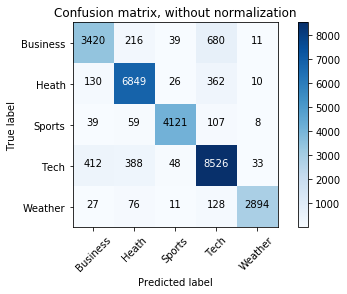

In [195]:
plt.show()

In [37]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    nmf_lables = nmf.transform(tfidf).argmax(axis=1)

    for topic_idx, topic in enumerate(model.components_):
        n_tweets = np.sum(nmf_lables == topic_idx)
        print "Topic %d: %d tweets" % (topic_idx, n_tweets)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])
        print
        

no_features = 1000
no_topics = 50

# Data cleaning



# NMF is able to use tf-idf
#tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweets_text_processed)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

"""
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweets_text_processed)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=15, learning_method='online', learning_decay=.9, learning_offset=50.,random_state=0)
lda.fit(tf)
"""

no_top_words = 20
display_topics(nmf, tfidf_feature_names, no_top_words)
#display_topics(lda, tf_feature_names, no_top_words)

Topic 0: 6329 tweets
forecast weather weather forecast watch evening weather watch evening evening @skynewsnaz forecast @skynewsnaz latest weather watch latest friday weather watch friday latest friday tuesday weather watch tuesday saturday weather watch saturday thursday weather
Topic 1: 15979 tweets
china bank trade deal tech canada big company market fund billion share buy war hit raise investment tariff government india
Topic 2: 1558 tweets
twitter live twitter watch starting miss live @markets twitter miss @markets live starting @markets #cheddarlive miss watch twitter watch @cheddar @cheddar live watch #cheddarlive starting @cheddar tap tap watch tune
Topic 3: 2783 tweets
health mental mental health insurance health insurance health news public health health care yahoo public @khnews health law law health risk health canada health official women gop kaiser affect
Topic 4: 3635 tweets
trump president president trump donald donald trump trump say kim kim jong jong administration pr

In [28]:
display_topics(nmf, tfidf_feature_names, no_top_words)


Topic 0: 6329 tweets
forecast weather weather forecast watch evening weather watch evening evening @skynewsnaz forecast @skynewsnaz latest weather watch latest friday weather watch friday latest friday tuesday weather watch tuesday saturday weather watch saturday thursday weather

Topic 1: 15979 tweets
china bank trade deal tech canada big company market fund billion share buy war hit raise investment tariff government india

Topic 2: 1558 tweets
twitter live twitter watch starting miss live @markets twitter miss @markets live starting @markets #cheddarlive miss watch twitter watch @cheddar @cheddar live watch #cheddarlive starting @cheddar tap tap watch tune

Topic 3: 2783 tweets
health mental mental health insurance health insurance health news public health health care yahoo public @khnews health law law health risk health canada health official women gop kaiser affect

Topic 4: 3635 tweets
trump president president trump donald donald trump trump say kim kim jong jong administratio

In [32]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1,
            verbose=True)
km.fit(tfidf)

Initialization complete
Iteration  0, inertia 255495.799
Iteration  1, inertia 130696.686
Iteration  2, inertia 130388.295
Iteration  3, inertia 130259.859
Iteration  4, inertia 130109.731
Iteration  5, inertia 130080.017
Iteration  6, inertia 130055.986
Iteration  7, inertia 130032.591
Iteration  8, inertia 130014.591
Iteration  9, inertia 130010.805
Iteration 10, inertia 130010.388
Iteration 11, inertia 130010.146
Iteration 12, inertia 130009.425
Iteration 13, inertia 130008.381
Iteration 14, inertia 130008.125
Iteration 15, inertia 130008.107
Iteration 16, inertia 130008.089
Iteration 17, inertia 130008.073
Iteration 18, inertia 130008.064
Iteration 19, inertia 130008.055
Iteration 20, inertia 130008.044
Iteration 21, inertia 130008.034
Iteration 22, inertia 130008.008
Iteration 23, inertia 130007.973
Iteration 24, inertia 130007.901
Iteration 25, inertia 130007.681
Iteration 26, inertia 130007.176
Iteration 27, inertia 130006.994
Iteration 28, inertia 130006.986
Iteration 29, inert

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=True)

In [33]:
clusters = {}
tweet_index = np.arange(len(tweets_text))
for center in range(km.n_clusters):
    clusters[center] = tweet_index[km.labels_ == center]

    

In [42]:
for i in range(km.n_clusters):
    print(" ".join(np.array(tfidf_vectorizer.get_feature_names())[tfidf[clusters[i]].sum(axis=0).argsort().tolist()[0][-20:]]))
    print

make news sources health billion confirm sky big world manager trade win sign #ssn tech company warn deal china breaking

treatment skin cancer risk know morning forward help day woman year people say risk breast cancer breast like look like cancer come look

friday latest watch friday friday weather watch latest latest weather today forecast @skyisobel @skyisobel watch today today weather forecast @skynewsnaz @skynewsnaz evening watch evening evening weather watch weather forecast weather forecast

@mikeclay wind story morning expect warm weather live sunny big juli watch marquez juli marquez high shower rain day amp today

tap twitter bloomberg starting @markets bloomberg @technology live bloomberg technology @cheddar live @technology @cheddar miss twitter watch #cheddarlive @markets live twitter miss @markets starting watch live twitter live twitter

trump new jersey launch jersey drug announce rule city report year new zealand zealand apple health say study new study new york york 

In [8]:
import pandas as pd
from sklearn.cluster import SpectralClustering
sample_tweets = pd.Series(tweets_text_processed).sample(30000)
tf = tf_vectorizer.fit_transform(sample_tweets)
corr = tf.dot(tf.T)


In [ ]:
sc = SpectralClustering(affinity='precomputed')
sc.fit(corr)

/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [131]:
metrics.silhouette_score?

In [36]:
n_tweet = tfidf.shape[0]
from sklearn import metrics
metrics.silhouette_score(tfidf, np.random.randint(10, size=(n_tweet)), metric='euclidean', sample_size=int(0.15 * tfidf.shape[0]))


-0.0012257220108786726

In [43]:
import gc

In [47]:
gc.collect()

9

In [46]:
metrics.calinski_harabaz_score(tfidf.toarray(), np.random.randint(10, size=(n_tweet)))  


1.0071915884758484

In [ ]:
sample = np.

In [48]:
metrics.calinski_harabaz_score(tfidf.toarray(), nmf_lables)

MemoryError: 

In [23]:
from sklearn import metrics
kmeans_lables = km.labels_
metrics.silhouette_score(tfidf, kmeans_lables, metric='euclidean', sample_size=int(0.15 * tfidf.shape[0]))


0.0006725186065137529

In [19]:
from sklearn import metrics
nmf_lables = nmf.transform(tfidf).argmax(axis=1)
metrics.silhouette_score(tfidf, nmf_lables, metric='euclidean', sample_size=int(0.15 * tfidf.shape[0]))


-0.019575675851550005

In [17]:
from sklearn import metrics
lda_lables = lda.transform(tf).argmax(axis=1)
metrics.silhouette_score(tf, lda_lables, metric='euclidean', sample_size=int(0.1 * tf.shape[0]))


-0.01753037973604478

In [33]:
tfidf_trans.shape

(50242, 20)

In [42]:
documents = np.array(documents)

In [25]:
tfidf = tfidf_vectorizer.fit_transform(tweets_text_processed)
tfidf_trans = nmf.transform(tfidf)

for topic, top_tweet in enumerate(tfidf_trans.argsort(axis=0)[-10:].T):
    print("topic %d:" % topic)
    for tw in top_tweet:
        print(tweets_text[tw], tweets_text_processed[tw])
    print
    print
    

topic 0:
(u'WATCH The Evening Weather Forecast https://t.co/R659lmIqMs', u'watch the evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/qyavr9egkI', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/5eWQ613btQ', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/u0sDf7aAQg', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/ZiXIBgJeSH', u'watch evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/goTrF7B19i', u'watch evening weather forecast')
(u'WATCH The Evening Weather Forecast https://t.co/7MgmPVGFnu', u'watch the evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/M41zgdXp69', u'watch evening weather forecast')
(u'WATCH The Evening Weather Forecast https://t.co/I9gy54unOI', u'watch the evening weather forecast')
(u'WATCH Evening Weather Forecast https://t.co/qSSXq8p46G', u'watch evening weather forecast')


topic 1:
(u'Thi

In [100]:
nmf.components_.shape

(1, 10000)

In [104]:
type(tfidf)

scipy.sparse.csr.csr_matrix

In [103]:
from scipy.spatial.distance import cdist
n_compnents_list = range(2, 11)
inertia = np.zeros(len(n_compnents_list))
for i, n_components in enumerate(n_compnents_list):
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    #tfidf_trans = nmf.transform(tfidf).argmax(axis=1)
    #centeroids = nmf.components_[tfidf_trans]
    inertia[i] = sum(np.min(cdist(np.array(tfidf), nmf.components_, 'euclidean'), axis=1)) / X.shape[0]


ValueError: XA must be a 2-dimensional array.

In [9]:
import gc

In [11]:
gc.collect()

9

In [18]:
i

12

In [21]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

tfidf = tfidf_vectorizer.fit_transform(tweets_text_processed)

n_compnents_list = range(1, 5) + range(5, 101, 5)
N = 10000
inertia = np.zeros(len(n_compnents_list))
for i, n_components in enumerate(n_compnents_list):
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
    tfidf_trans = nmf.transform(tfidf).argmax(axis=1)
    for j in range(tfidf.shape[0]/N+1):
        centeroids = nmf.components_[tfidf_trans[j* N : (j+1)*N]]
        inertia[i] += np.sum(np.array(tfidf[j* N : (j+1)*N] - centeroids)**2)
    inertia[i] /= tfidf.shape[0]
    print(inertia[i])
    gc.collect()

106.49422629003186
145.90248300604395
142.0990577201488
134.08227502699341
130.1154504484397
105.41161167036684
94.2708190647544
87.5593587479236
78.42152612651941
78.75663630364899
65.38470274979358
71.54629034877355
65.08328636445574
62.37824161130139
59.985429827092965
58.03311357686433
55.87978054163262
55.20680949402814
53.328683234907075
54.30538485367143
52.189404424825476
52.28693906057919
50.260926235932516
49.6787383058521


In [24]:
import matplotlib.pyplot as plt
plt.plot(n_compnents_list, inertia);
plt.grid(True)

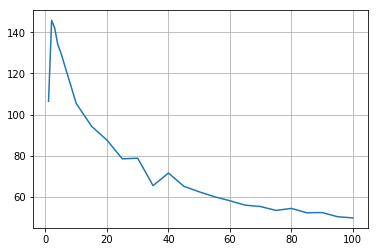

In [25]:
plt.show()

In [66]:

def predict_cluster(tweet_text):
    tweets_text_processed = prep.fit_transform(tweet_text)
    tfidf = tfidf_vectorizer.transform(tweets_text_processed)
    nmf_components = nmf.transform(tfidf)
    nmf_lables = nmf_components.argmax(axis=1)
    print(nmf_components.sum())
    return sorted(nmf_components[0], reverse=True)[:5]


In [39]:
tweets_text[0:1]

array([u"She's 89, deaf and suffering from dementia. Is the busy care system isolating her further? https://t.co/O49eQt02ZP https://t.co/72SN3it2to"],
      dtype='<U156')

In [61]:
text = u'President Trump could invite Kim Jong Un to Mar-a-Lago for follow-up summit: official https://t.co/cQtW76957F'


In [67]:
predict_cluster([text])

0.08676606370436071


[0.04869959142681163, 0.03803818559604331, 2.8286681505783057e-05, 0.0, 0.0]

In [60]:
from pymongo import MongoClient
import json
from tweepy import Stream
from tweepy.streaming import StreamListener
import numpy as np

class MyListener(StreamListener):
 
    def on_data(self, data):
        global cnt
        try:
            tweet = json.loads(data)
            #tweets_collection.insert_one(tweet)
            text = tweet['text']
            print(text, predict_cluster([text]))
            cnt += 1
            if cnt % 1000 == 0:
                print(cnt)
            if cnt == max_count:
                twitter_stream.disconnect()
                print("done!")
                
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return True
 
    def on_error(self, status):
        print(status)
        return True

#client = MongoClient()
#tweets_collection = client.tweets_db.tweets

cnt = 0
max_count = 100
twitter_stream = Stream(auth=auth, listener=MyListener())
GEOBOX_US_CANADA = [-128.755117, 26.415893, -52.437305, 54.093165]
twitter_stream.filter(locations=GEOBOX_US_CANADA, async=True)
client.close()

(u'@SportsCenter @wojespn Now This is the addition LA needed. A \u201cproven\u201d PG who can distribute and drop dimes to James\u2026 https://t.co/94PtwtpFoA', [0.024657690522807342, 0.00010677272750391116, 0.0, 0.0, 0.0])
(u'Nakakakilig yung MarNigo @MissMarisRacal @ImPascualInigo \U0001f60d\U0001f60d\U0001f60d\U0001f60d #TWBAMariStellar', [0.0, 0.0, 0.0, 0.0, 0.0])
(u'\u201c90210\u201d \U0001f31e\U0001f334 https://t.co/DgooJQ7BRg', [0.0, 0.0, 0.0, 0.0, 0.0])
(u'Well other people that weren\u2019t military children lol', [0.04333330670839242, 0.028974032627738622, 0.0, 0.0, 0.0])
(u'Preview of my latest project... I foresee something amazing!! #fixerupper #painted #smalltown #elkriver @ Painted https://t.co/XgEAWNhqMd', [0.0009995732222980332, 0.0009855645179060108, 0.0007012085471454119, 0.0003583227129240908, 0.0])
(u'#GOPComplicit \n#GOPCorruption https://t.co/oKWAaEAjq6', [0.0, 0.0, 0.0, 0.0, 0.0])
(u"If you're looking for work in #Covina, CA, check out this #job: https://t.co/Z7

In [53]:
twitter_stream.disconnect()


Error on_data: 'inplace' is an invalid keyword argument for this function
